# Sound Classification Vision Learning using Fastai v2

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sbavery/ml-examples/blob/main/nbs/02_classification_sound.ipynb)

> Tested using Google Colab Pro, Windows 10 Anaconda Python3.7 and WSL Python3.10 w/ CUDA and NVIDIA GTX 1050 Ti

> **Colab**: Recommended to run using GPU and high ram runtime

Please follow along for an example of converting audio files (.wav) into spectrogram images that can be fed into a fastai vision learner for sound classification! For this example, the UrbanSound8K database is used:

https://urbansounddataset.weebly.com/urbansound8k.html

This following notebook is derived from the two examples linked below and has been upgraded to work with Fastai v2.7.9:

Dipam Vasani: https://towardsdatascience.com/sound-classification-using-images-68d4770df426

Plaban Nayak: https://nayakpplaban.medium.com/sound-classification-using-fastai-b82678875af

## Installation and Setup

In [ ]:
## Install Libraries
# matplotlib provides a wide host of plotting capabilities for data analysis
#!pip install matplotlib

# https://www.fast.ai/
#!pip install fastai

# librosa provides audio file conversion into spectrogram images
#!pip install librosa

# wget provides Windows and Linux file download compatibility
#!pip install wget

# On WSL / Linux, you may need to install libsndfile
# sudo apt-get install libsndfile1

In [ ]:
# General Utilities
import warnings
warnings.filterwarnings('ignore')
import os
import wget
import glob
import shutil 
import tarfile

# Machine Learning
from fastai import *
from fastai.vision.all import *

# Sound & Imagery Handling
import IPython
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import librosa
import librosa.display

# Autoreload modules before code execution
%reload_ext autoreload
%autoreload 2
# Plot inline within the notebook
%matplotlib inline

In [ ]:
## Utility Function to Check GPU Status
def check_gpu():
    print("CUDA Available: ", torch.cuda.is_available())
    num_devices = torch.cuda.device_count()
    if num_devices > 0:
        for device in range(0,num_devices):
            print("Device", device, "|", torch.cuda.get_device_name(device), 
            "| Allocated:", round(torch.cuda.memory_allocated(device)/1024**3,1), "GB",
            "| Cached:", round(torch.cuda.memory_reserved(device)/1024**3,1), "GB")

#torch.cuda.empty_cache()
check_gpu()

## Data Collection and Inspection

In [ ]:
os.getcwd()

In [ ]:
def data_dl_extract(url, dl_path, chdir=False, ignore_existing=True):
    import os, wget, tarfile
    ignore = os.path.exists(dl_path) and ignore_existing
    if os.path.exists(dl_path) == False: os.mkdir(dl_path)
    if (os.getcwd() != dl_path, chdir == True): os.chdir(dl_path)

    if ignore == False:
        download = wget.download(url)
        try:
            my_tar = tarfile.open(download)
            my_tar.extractall(dl_path) # specify which folder to extract to
            my_tar.close()
        except:
            print("WARNING: Data extraction failed")
            print("Data stored here:",download)

url = "https://goo.gl/8hY5ER"
dl_path = os.getcwd()+"/data/"
data_dl_extract(url, dl_path, chdir=True)
os.getcwd()

'/home/ses/workspace/ml-examples/nbs/data'

In [ ]:
## Define Data Paths and Labels
audio_path = dl_path+"UrbanSound8K/audio/"
spectrogram_path = dl_path+"UrbanSound8K/spectrogram/"
data_path = dl_path+"UrbanSound8K/data/"
if os.path.exists(spectrogram_path) == False: os.mkdir(spectrogram_path)
if os.path.exists(data_path) == False: os.mkdir(data_path)

n_folds = 10

labels  = ['air_conditioner','car_horn','children_playing','dog_bark',
        'drilling','engine_idling','gun_shot','jackhammer','siren','street_music']

In [ ]:
## Listen to an audio file - **WARNING** may be loud
IPython.display.Audio(audio_path+"fold1/26270-9-0-35.wav")

## Create and Store Spectrogram Images

The UrbanSound8K database has been pre-organized into 10 folds for 10-fold cross validation. Here is what we will do:
1. create_fold_spectrograms for each fold
    * Convert .wav audio files into spectrogram .png images
2. create_fold_directory for each fold
    * Store *this folds' spectrograms as validation data*, and combine all *other folds as training data*

In [ ]:
def create_fold_spectrograms(fold, display=False):
    if os.path.exists(spectrogram_path+fold) == False: os.mkdir(spectrogram_path+fold)
    audio_filepaths = glob.glob(audio_path+'fold'+fold+'/*.wav')
    if display: print("Generating Spectrograms for Fold "+fold)

    for audio_filepath in audio_filepaths:
      audio_file = os.path.basename(audio_filepath)
      image_filepath = spectrogram_path+fold+'/'+audio_file.replace('.wav','.png')
      if os.path.exists(image_filepath) == False:
        samples, sample_rate = librosa.load(audio_filepath)
        fig = plt.figure(figsize=[0.72,0.72])
        ax = fig.add_subplot(111)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_frame_on(False)
        S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
        plt.savefig(image_filepath, dpi=400, bbox_inches='tight',pad_inches=0)
        plt.close('all')

In [ ]:
for i in range(1, n_folds+1):
    create_fold_spectrograms(str(i), display=True)

Generating Spectrograms for Fold 1
Generating Spectrograms for Fold 2
Generating Spectrograms for Fold 3
Generating Spectrograms for Fold 4
Generating Spectrograms for Fold 5
Generating Spectrograms for Fold 6
Generating Spectrograms for Fold 7
Generating Spectrograms for Fold 8
Generating Spectrograms for Fold 9
Generating Spectrograms for Fold 10


In [ ]:
def create_fold_directory(fold, n_folds, display=False):
    spectrogram_filepaths = glob.glob(spectrogram_path+fold+'/*.png')
    if os.path.exists(data_path+fold) == False: os.mkdir(data_path+fold)
    if os.path.exists(data_path+fold+'/train') == False: os.mkdir(data_path+fold+'/train')
    if os.path.exists(data_path+fold+'/valid') == False: os.mkdir(data_path+fold+'/valid')
    
    for label in labels:
        if os.path.exists(data_path+fold+'/train/'+label) == False: os.mkdir(data_path+fold+'/train/'+label)
        if os.path.exists(data_path+fold+'/valid/'+label) == False: os.mkdir(data_path+fold+'/valid/'+label)
    if display: print("Moving Fold "+fold+" Spectrograms to Labeled Folders")
     
    for spectrogram_filepath in spectrogram_filepaths:
        file = os.path.basename(spectrogram_filepath)
        label = file.split('-')[1]
        spectrogram_valid_path = data_path+fold+'/valid/'+labels[int(label)]+'/'+file
        if os.path.exists(spectrogram_valid_path) == False: shutil.copyfile(spectrogram_filepath, spectrogram_valid_path)
    for i in range(1, n_folds+1):
        if fold == str(i): continue       
        spectrogram_filepaths = glob.glob(spectrogram_path+str(i)+'/*.png')
        for spectrogram_filepath in spectrogram_filepaths:
            file = os.path.basename(spectrogram_filepath)
            label = file.split('-')[1]
            spectrogram_train_path = data_path+fold+'/train/'+labels[int(label)]+'/'+file
            if os.path.exists(spectrogram_train_path) == False: shutil.copyfile(spectrogram_filepath, spectrogram_train_path) 

In [ ]:
for i in range(1, n_folds+1):
    create_fold_directory(str(i), n_folds, display=True)

Moving Fold 1 Spectrograms to Labeled Folders
Moving Fold 2 Spectrograms to Labeled Folders
Moving Fold 3 Spectrograms to Labeled Folders
Moving Fold 4 Spectrograms to Labeled Folders
Moving Fold 5 Spectrograms to Labeled Folders
Moving Fold 6 Spectrograms to Labeled Folders
Moving Fold 7 Spectrograms to Labeled Folders
Moving Fold 8 Spectrograms to Labeled Folders
Moving Fold 9 Spectrograms to Labeled Folders
Moving Fold 10 Spectrograms to Labeled Folders


## Data Loading and Exploratory Training

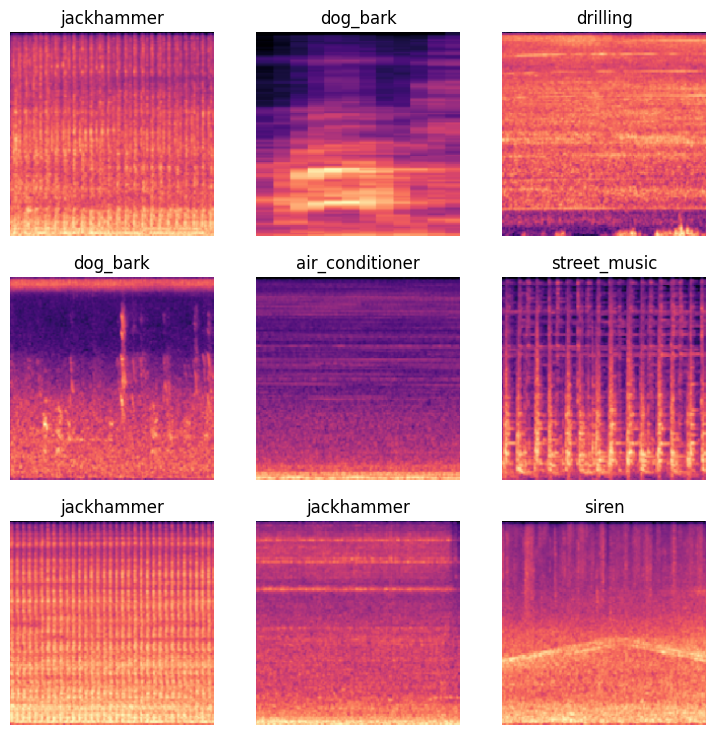

In [ ]:
fold = 1
data = ImageDataLoaders.from_folder(data_path + str(fold), 
                                    item_tfms = Resize(224),
                                    batch_tfms = [Normalize.from_stats(*imagenet_stats)])
data.show_batch()

SuggestedLRs(valley=0.0014454397605732083)

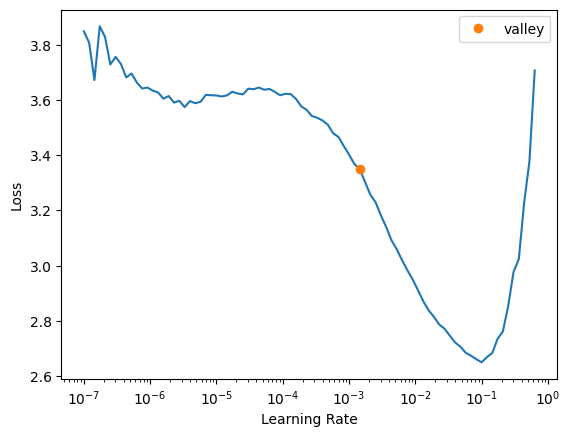

In [ ]:
## Create a Vision Learner (using a CNN under the hood)
# Transfer learning using Resnet
learn = vision_learner(data, resnet34, metrics=accuracy)
learn.lr_find()

In [ ]:
# Set the base Learning Rate
lr = 1E-3

In [ ]:
# Fit one cycle, making sure to avoid overfitting (valid_loss >> train_loss or valid_loss increases)
learn.fit_one_cycle(2,lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.289454,0.810938,0.744559,01:28
1,0.731260,0.783540,0.734250,01:27


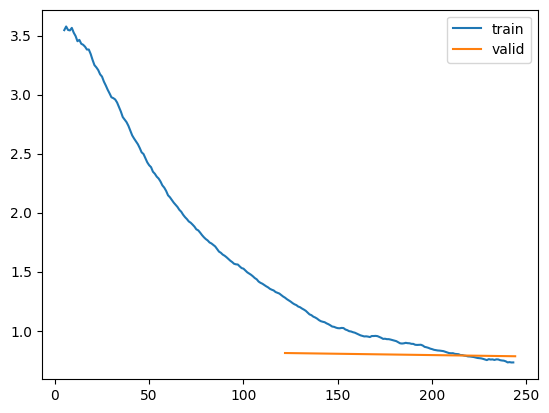

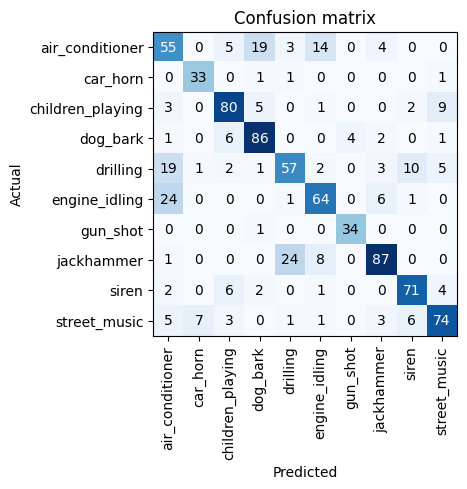

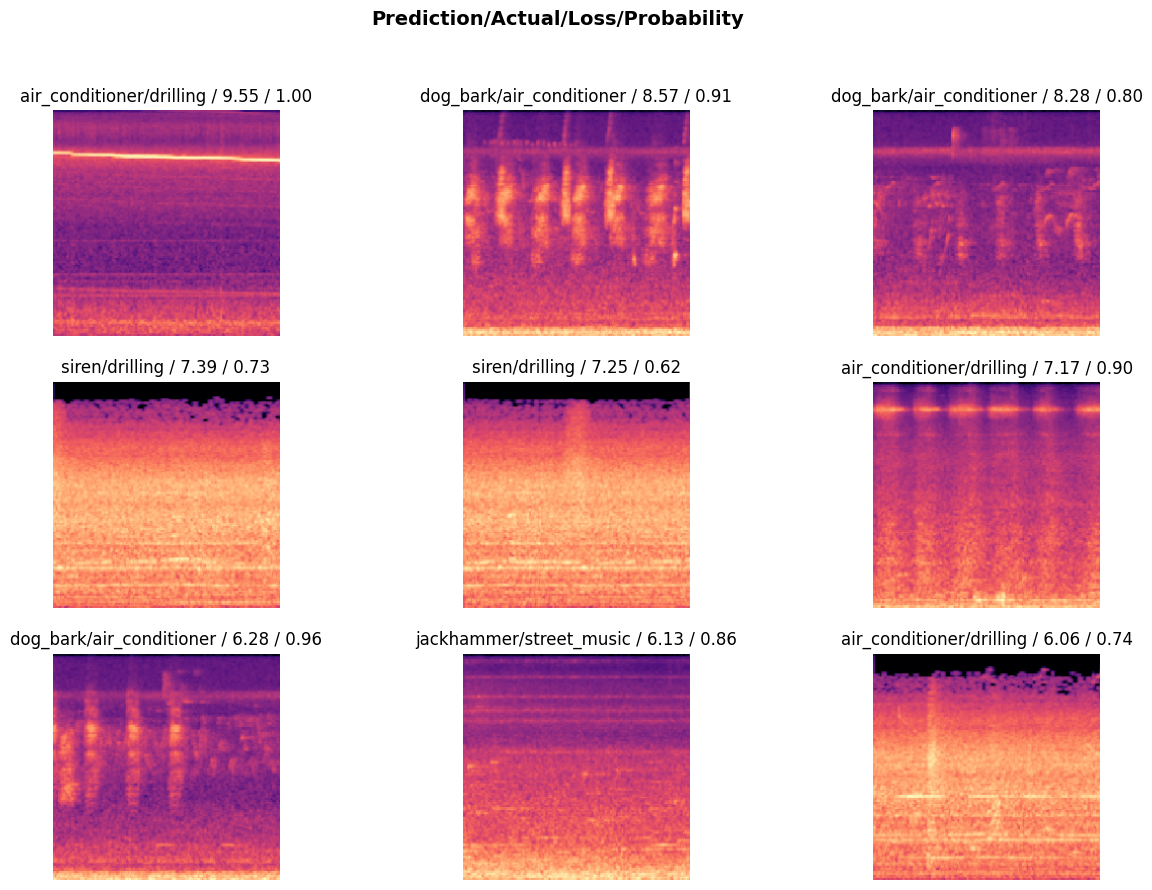

In [ ]:
def interpret(learner):
  learner.recorder.plot_loss()
  interp = ClassificationInterpretation.from_learner(learner)
  interp.plot_confusion_matrix()
  interp.plot_top_losses(9, figsize=(15,10))

interpret(learn)

#### Freezing and Unfreezing the Model
Since we are transfer learning, we may be able to eek out from additional performance by *re-training* part or all of the model layers that are not optimized for this specific type of feature detection. However, this could also lead to overfitting on the training data. See this forum post for some good analogies!

https://forums.fast.ai/t/can-anyone-explain-me-what-does-freeze-and-unfreeze-do/42025

epoch,train_loss,valid_loss,accuracy,time
0,0.542763,0.894804,0.766323,01:53


SuggestedLRs(valley=3.630780702224001e-05)

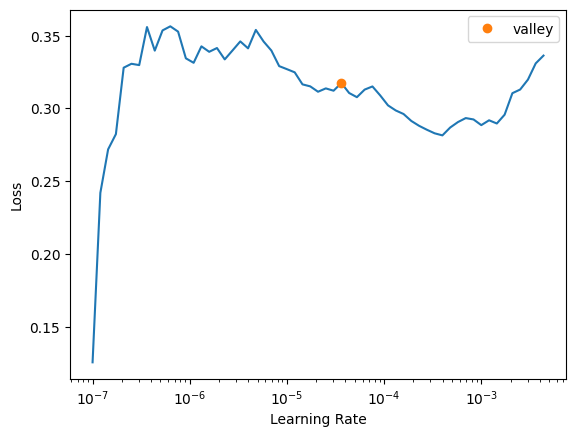

In [ ]:
# Unfreeze to re-train all layers
#learn.unfreeze()

# Freeze_to allows re-training a specified number of layers
learn.freeze_to(-3)
learn.fit_one_cycle(1)
learn.lr_find()

In [ ]:
## Specify lr min and max to progressively get smaller across epochs
lr_min = 1E-6
lr_max = 5E-4

epoch,train_loss,valid_loss,accuracy,time
0,0.247294,0.865435,0.791523,01:53
1,0.186535,0.928034,0.790378,01:53


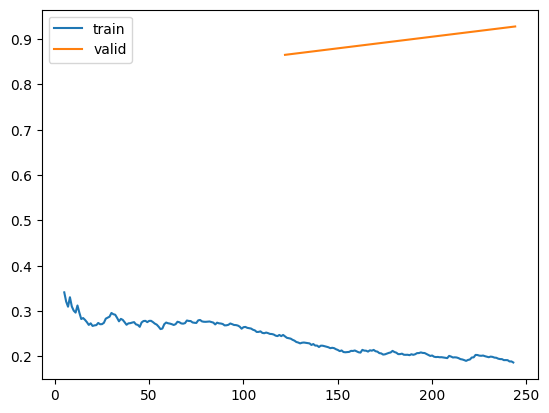

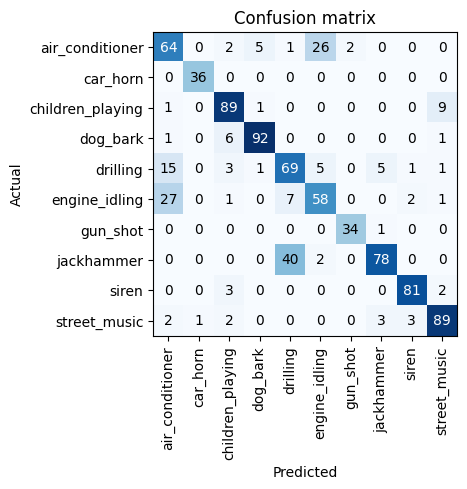

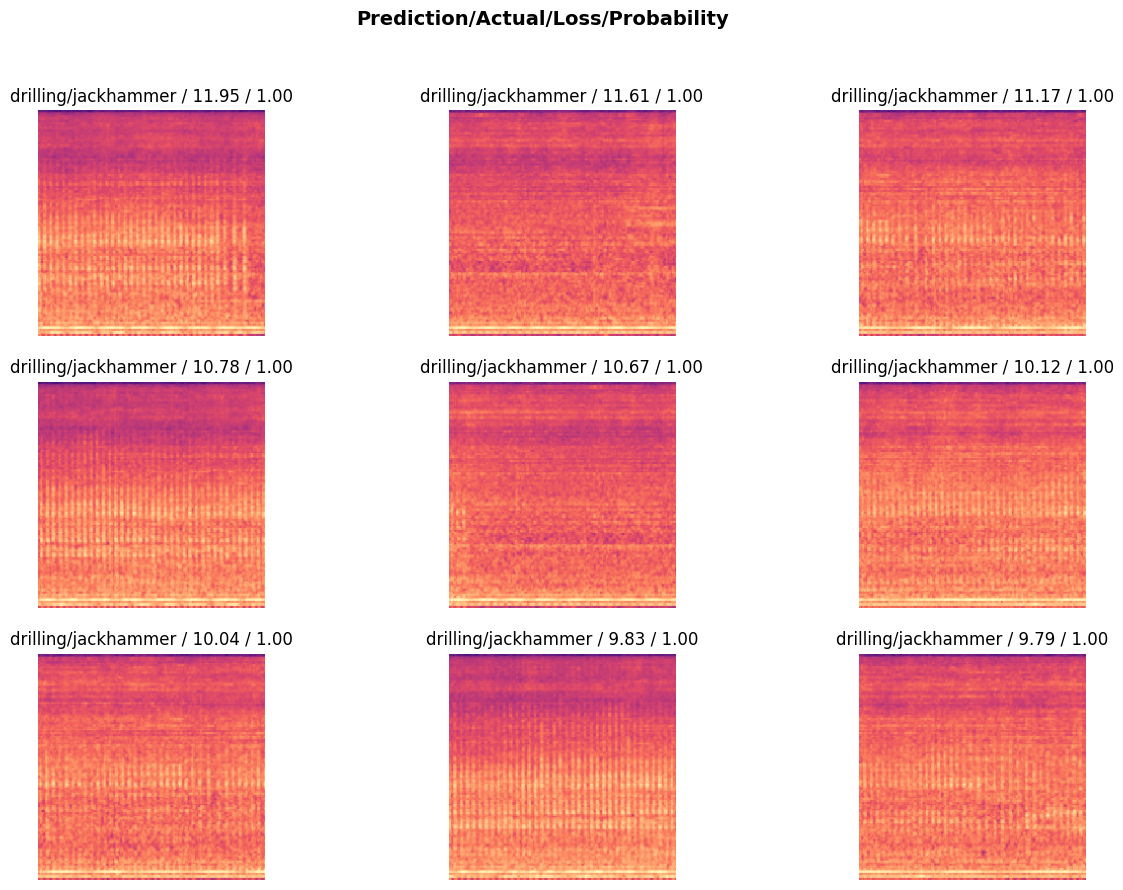

In [ ]:
## Running fit_one_cycle again can improve performance by starting where prior performance left off
learn.fit_one_cycle(2, lr_max=slice(lr_min,lr_max))
interpret(learn)

## Fit the Model for all Folds

In [ ]:
def process_fold(fold, lr, lr_min, lr_max):
    data = ImageDataLoaders.from_folder(data_path + fold, 
                                        item_tfms = Resize(224),
                                        batch_tfms = [Normalize.from_stats(*imagenet_stats)])
    learn = vision_learner(data, resnet34, metrics=accuracy)
    learn.fit_one_cycle(2, lr)
    learn.freeze_to(-3)
    learn.fit_one_cycle(1, lr)
    learn.fit_one_cycle(2, lr_max=slice(lr_min,lr_max))
    return learn

In [ ]:
learners = []
results = []
for i in range(1, 3):#n_folds+1):
    print("Process Fold "+str(i))
    learn = process_fold(str(i), lr, lr_min, lr_max)
    results.append(learn.metrics[0].value)
    learners.append(learn)

Process Fold 1


epoch,train_loss,valid_loss,accuracy,time
0,1.339008,0.834174,0.731959,01:29
1,0.748324,0.784159,0.743414,01:29


epoch,train_loss,valid_loss,accuracy,time
0,0.584868,0.837604,0.759450,01:53


epoch,train_loss,valid_loss,accuracy,time
0,0.276395,0.904560,0.781214,01:53
1,0.198695,0.905414,0.789233,01:54


Process Fold 2


epoch,train_loss,valid_loss,accuracy,time
0,1.303935,1.184880,0.674550,01:28
1,0.722099,1.278374,0.693694,01:29


epoch,train_loss,valid_loss,accuracy,time
0,0.539881,0.800606,0.790541,01:54


epoch,train_loss,valid_loss,accuracy,time
0,0.233707,0.697887,0.826577,02:00
1,0.194457,0.745437,0.817568,02:07


In [ ]:
mean_r = np.round(np.mean(results),2)
max_r = np.round(np.max(results),2)
min_r = np.round(np.min(results),2)
print("Validation Accuracy Mean:",mean_r,"/ Max:",max_r,"/ Min:",min_r)

Validation Accuracy Mean: 0.8 / Max: 0.82 / Min: 0.79


While the accuracy is relatively good, we are likely overfitting (validation loss > training loss) and should continue tweaking the model to try to avoid this.

In [ ]:
#for i in range(1, n_folds+1):
#    print("Interpret Learner for Fold",i)
#    interpret(learners[i])